## HW6 - Question 2 - Initial GAN

In [14]:
pip install pytorch-fid

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn.functional import binary_cross_entropy_with_logits as bce_loss
import torch.optim as optim
import matplotlib.gridspec as gridspec
import math
import torchvision.transforms as T
from torchvision.utils import save_image
import os
from pytorch_fid.fid_score import calculate_fid_given_paths

In [16]:
train_dataset = datasets.MNIST(root = './MINST_dataset', train = True, transform = T.ToTensor(), download = True)
test_dataset = datasets.MNIST(root = './MINST_dataset', train = False, transform = T.ToTensor(), download = True)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 128, drop_last=True, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 128, drop_last=True, shuffle = True)

In [17]:
num = 0;
for real_data, _ in train_loader:
      num = num +1
print(num)

468


In [18]:
class reshape(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.reshape(x.size(0), *self.shape)

class discriminatorNet(nn.Module):
    def __init__(self, d_input_dim = 1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(d_input_dim, 32, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU(),
            reshape(64 * 7 * 7),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )
    def forward(self, d):
        return self.model(d)

class generatorNet(nn.Module):
    def __init__(self, g_input_dim = 64, g_output_dim = 1):
        super().__init__()
        self.g_input_dim = g_input_dim
        self.model = nn.Sequential(
            nn.Linear(g_input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 64 * 7 * 7),
            nn.BatchNorm1d(64 * 7 * 7),
            nn.ReLU(),
            reshape(64, 7, 7),
            nn.PixelShuffle(2),
            nn.Conv2d(16, 32, kernel_size = 3, padding =  1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.PixelShuffle(2),
            nn.Conv2d(8, g_output_dim, kernel_size = 3, padding = 1),
            nn.Tanh()
        )
    def forward(self, g):
        return self.model(g)

In [19]:
def sample_noise(batch_size, dim):
    return torch.rand(batch_size, dim, dtype = torch.float32) * 2 - 1

In [20]:
def discriminator_loss(logits_real, logits_fake):
  loss_pos = bce_loss(logits_real, torch.ones_like(logits_real))
  loss_neg = bce_loss(logits_fake, torch.zeros_like(logits_fake))
  loss = loss_pos + loss_neg
  return loss

def generator_loss(logits_fake):
  loss = bce_loss(logits_fake, torch.ones_like(logits_fake))
  return loss

In [21]:
def get_optimizer(model):
  optimizer = optim.Adam(
      model.parameters(),
      lr=1e-3,
      betas=(0.5, 0.999)
  )
  return optimizer

In [22]:
def show_images(images):
  images = torch.reshape(images, [images.shape[0], -1])
  a = int(math.ceil(math.sqrt(images.shape[0])))
  b = int(math.ceil(math.sqrt(images.shape[1])))

  fig = plt.figure(figsize=(a/2, a/2))
  gs = gridspec.GridSpec(a, a)
  gs.update(wspace=0.05, hspace=0.05)

  for i, img in enumerate(images):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_aspect(1)
    plt.imshow(img.reshape([b,b]))
  return

In [28]:
def run(D, G, D_opt, G_opt, D_loss, G_loss, batch_size = 128, num_epochs = 10):
  iter = 0
  D_losses = []
  G_losses = []

  for epoch in range(num_epochs):
    for real_data, _ in train_loader:
      D_opt.zero_grad()
      noise = sample_noise(batch_size, 64)
      fake_images = G(noise).detach()
      D_fake_logits = D(fake_images.view(batch_size, 1, 28, 28))
      real_logits = D(2*real_data - 1)

      D_error = D_loss(real_logits, D_fake_logits)
      D_error.backward()
      D_opt.step()

      G_opt.zero_grad()
      noise = sample_noise(batch_size, 64)
      fake_images = G(noise)

      G_fake_logits = D(fake_images.view(batch_size, 1, 28, 28))
      G_error = G_loss(G_fake_logits)
      G_error.backward()
      G_opt.step()

      if (iter % 20 == 0):
        D_losses.append(D_error.item())
        G_losses.append(G_error.item())

      if (iter % 468 == 0):
        print('iteration:', iter)
        imgs_numpy = fake_images.data.cpu()
        show_images(imgs_numpy[0: 100])
        plt.show()
        print()
      iter += 1

  plt.plot(G_losses, label='Generator loss', alpha = 0.7)
  plt.plot(D_losses, label='Discriminator loss')
  plt.xlabel('Iteration / 20')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

iteration: 0


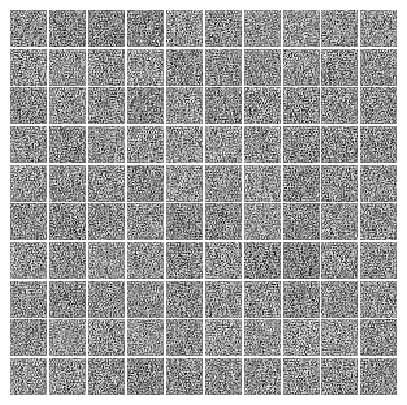


iteration: 468


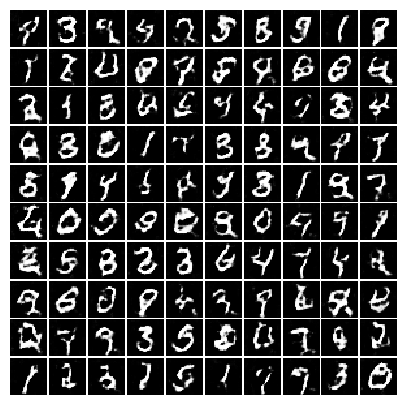


iteration: 936


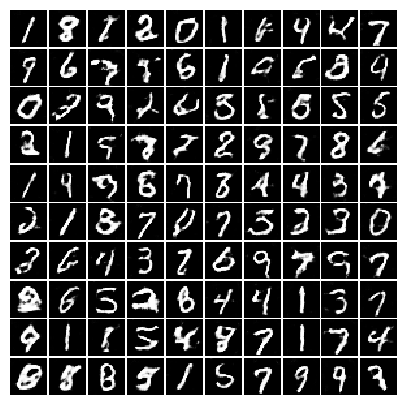


iteration: 1404


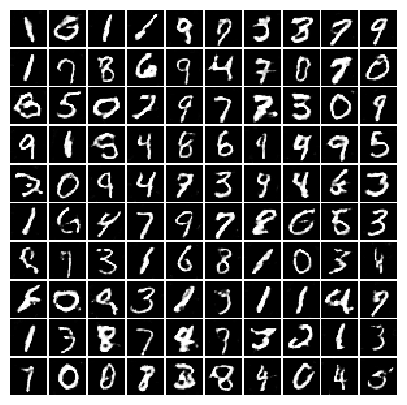


iteration: 1872


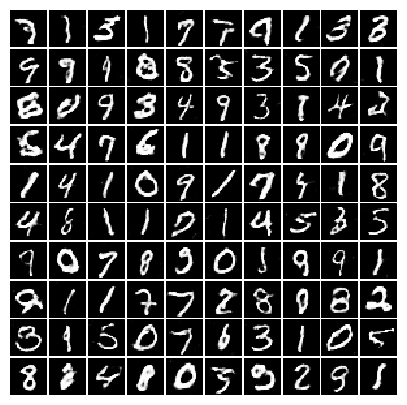


iteration: 2340


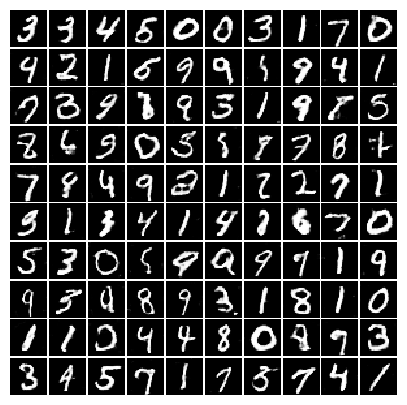


iteration: 2808


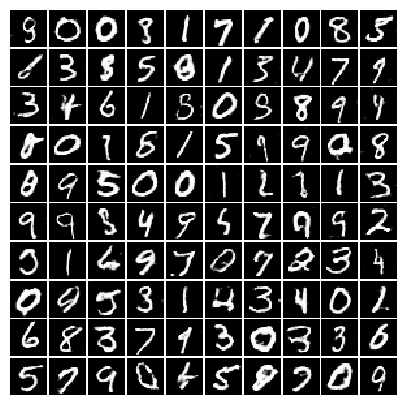


iteration: 3276


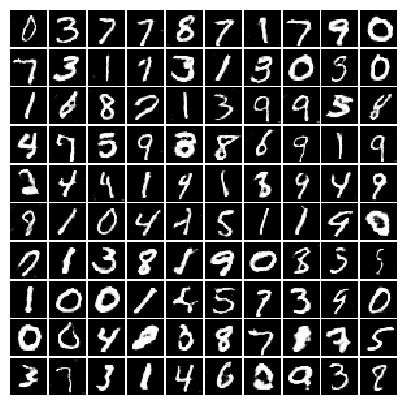


iteration: 3744


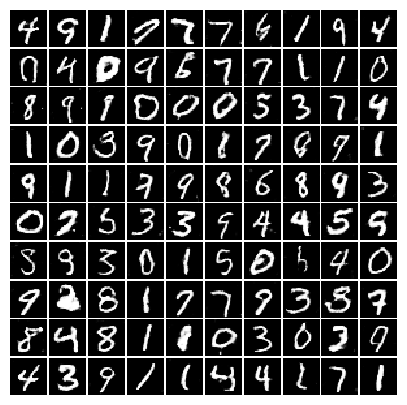


iteration: 4212


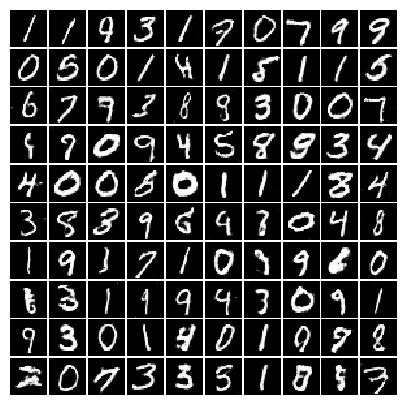

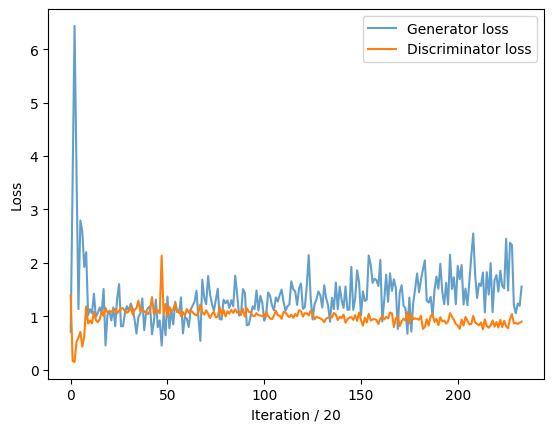

In [29]:
D = discriminatorNet()
G = generatorNet()

%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

run(D, G, get_optimizer(D), get_optimizer(G), discriminator_loss, generator_loss)

In [30]:
test_data = test_loader.dataset.data.reshape(-1, 784).float()/127 - 1

In [31]:
os.makedirs('./real_images', exist_ok=True)
for i, image in enumerate(test_data):
    image = (image + 1) /2
    save_image(image.reshape(28, 28), os.path.join('./real_images', f"real_{i}.png"))

os.makedirs('./fake_images', exist_ok=True)
fake_images = G(torch.randn(5000, 64))
for i, image in enumerate(fake_images):
    image = (image + 1) /2
    save_image(image.reshape(28, 28), os.path.join('./fake_images', f"fake_{i}.png"))


In [32]:
use_cuda = torch.cuda.is_available()
fid_score = calculate_fid_given_paths(
    ['./real_images', './fake_images'],
    batch_size=100,
    dims=2048,
    device = torch.device("cuda" if use_cuda else "cpu")
)
print(f'FID Score: {fid_score:.4f}')

100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


FID Score: 15.0679
